In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.transforms import Affine2D
from sklearn.decomposition import PCA 
import cv2
import pandas as pd
from os import listdir
from os.path import isfile, join
import skimage.io

# Principal Component Analysis
##### Final project

*Viktor Belchev - student*

*Math Concepts for Developers - Software University*

*May 2020*

### Abstract
Sometimes a projection of a higher-dimensional to a lower-dimensional space is useful. It's extremely useful if we want to get some visual understanding of a, say, 15D space, in 3D or even 2D. As the sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms, such projection reduces the computational complexity of the model which in the case of Machine learning makes the overall algorithms run faster. It is always a question and debatable how much accuracy it is sacrificing to get less complex and reduced dimensions data set. There is no concrete answer for this. However we ailways try to keep most of the variance while choosing the final set of components. 

An algorithm which allows us to project multidimensional data into fewer dimensions **while keeping the most important shapes and structures** is called **principal component analysis** (PCA). 

In this notebook I will explore PCA using the following checklist:

***I.*** **Introduction** where I will try to explain the theory by showing the math behind and answering the questions like: what are eigenvalues and eigenvectors? What is the eigenbasis? What is the spectrum of a matrix? How do we compute the eigenvalues and eigenvectors of a matrix? What is projection? How does projection conserve some shapes? How is the projection problem related to eigenvalues and eigenvectors?

***II.*** **What is PCA?** Here I will try to explain further what are principal components, and how many components are there (as a function of dimensions of the original space). There will be need to put in the checklist the answers of the questions like: What is variance? What is explained variance? How do principal components relate to explained variance?

***III.*** **Implementation of PCA in Python.** How is PCA implemented? Implementation on 2 dataset with different libraries: 2D and Eigenfaces.

***IV.*** **Conclusion**. In practice. Some misuses and alternative methods.

***I.*** **Introduction** 

* What are eigenvalues and eigenvectors?

Before explaining what are they, I will try to explain why are we interested in them.
Well, we are interested in them because they are components of a dataset that can help us represent (or make a projection of) a multi-dimentional dataset in a smaller dimension (let's say like a 3D real life image to a 2D image on a screen). How can we use them for trasforming the size of the dimensions? By finding these specific vectors, as they are in fact the **"axis of rotation"**, the transformation matrix linked with these vectors can be expressed by a simple $scalar$ or $eigenvalues$. And yes, they are linked as the $eigenvalue$ (officially expressed using the greek letter $\lambda$) represents the **length** or the **magnitude** of an $eigenvector$ $\vec{v}$ (a non-zero vector by definition) that is equal to the transformation of this **matrix A**. On other words, in the direction set by the $eigenvector$ the transformation of a given matrix **A** is nothing but a linear transformation (scaling) defined in magnitude by the magnitude of the $eigenvalue$. Wehn we find these values, the whole system becomes linear and we can apply all the laws we know from the Linear Algebra and make them predictable and signify the dominance of certain behaviours within a system. 

Mathematically, this link can be presented by the following equation:

$$A\vec{v} = \lambda\vec{v} $$

In the case of transforming a 3D into 2D this matrix will be $3 \times 3$, for **n**-dimention this matrix would be of $n \times n$, so the roots of this equation will be $3$ or $n$ and the size of the $eigenvector$ will be $1 \times 3$ or $1 \times n$ respectively.

* What is the eigenbasis? What is the spectrum of a matrix?

In fact, the set of roots $\lambda$ explained above represent itself the **spectrum of the matrix A**.

As we know each two vectors that are not linearly dependent in 2D space form a basis ($span(\vec{e_1}, \vec{e_2}) = \mathbb{R^2} => basis )$. (BTW, that was the idea of the Problem 1, Problem 3 and  Problem 6 in this Linear Algebra Exercise with the last one dealing more concretely with the $eigenvectors$, thus forming an $eigenbasis$.) From here, we already know that a set of basis vectors that are also $eigenvectors$ in the same space (dimention) - and thus can be represented via these $eigenvectors$ and their respective constants $\lambda_1$ and $\lambda_2$ ($eigenvalues$) - is called an $eigenbasis$.

Now, usually, it will be perfect to set these $eigenbasis$ in a way that we can easely orient ourself, or by tying them up to some well known coordinate system. That is possible if we are able to prove that the $eigenvectors$ are orthogonal. That is the case if the transformation matrix **A** is *symmetric*. Then, we  use another matrix of transformation that has a diagonal values of $\lambda$s only, or a Diagonal $D - matrix$ and if we take the matix of our $eigenvectors$' values $E$ and multiply it to the transformation matrix $A$ and then again multiply it by the transposed version of the matix of our $eigenvectors$' values $E^T$ we will get to this diagonal $D-matrix$.

$$ E A E^T = D $$

In case the roots of the equation are not in $\mathbb{R}$, we should use the inverse of $E$ to satisfy this equation:

$$ A = E D E^{-1} $$

This is also called an $eigendecomposition$ of a matrix.

Once we have orthogonal $eigenvectors$ we can go further and make them orthonormal by using the equation for each $eigenvector$:
$$ \vec{u_i} = \left( \frac{1}{\sqrt{\vec{e_{i}^T} \vec{e_i}}} \right) \vec{e_i} $$

* How do we compute the eigenvalues and eigenvectors of a matrix?

The calculation is not that complicated. The only way to squish this matrix **A** is by by simply finding the roots of the deterninant:

$$det(\lambda I_n - A) = 0$$ 

Yes, the determinant, because for a non-zero vector $\vec{v}$ as shown above, the equation 
$$\lambda\vec{v} - A\vec{v} = 0$$ 
will be true if and only if 
$$(\lambda I_n - A) = 0$$ 
We can't simply substract a scalar from a matrix. That is why we need to insert $I_n$, which is the *Identity* matrix where again $n$ is the size of the dimention. The last will be true is its determinant is 0.
Consequently for each root $\lambda$  - an $eigenvalue$ - we will get to concrete $\vec{v_\lambda}$, or also $\vec{e}$, that we can call $eigenvector$.

Next, we must understand what a *projection* is.

* What is projection?

A projection is a linear algebra concept that helps us understand many of the mathematical operations we perform on high-dimensional data. As our aim is to transform a $d$-dimentional space to $k$-dimentional subspace (i.e. $d > k$), **"projection"** is in fact a mapping of d-space onto k-space. 

The projection of a point to subspace is the place that is closest to the original point, or the projections minimize the distance between points and subspace. We know from geometry that we can find this closest point by dropping a perpendicular line from the point (the object) in the space $d$ to the $k$-space. Thus, we can think of it as a shadow on this lower subspace resulting from an object and a perpendicular light to the subspace $k$ coming from behind the object by standing in the $d$-dimention (source: Khan Academy). (Using the *distance minimization approach* is one of the methods to define the First Component in the PCA.)

In maths terms in $d$-dimensional space a projection $\vec{x'}$ of a vector $\vec{x}$ over another one (suppose $\vec{e}$ is any vector) is in fact the result of the dot-product operation:
$$ \vec{x'} = \vec{x^T} \vec{e}  = \sum_{j=0}^{d} x_{ij}e_{j}$$

* How does projection conserve some shapes? 

Thinking about the example of an object casting a shadow, despite being casted, we instinctively know that this projection conserves some of the object's features, as they are reflected on the lower dimention, thus that requires less memory that the original data. Therefore we can say that it is a lossy compression as we lose as little precision as possible.

* How is the projection problem related to eigenvalues and eigenvectors?

And this is where the projection can be related with $eigenvalues$ and $eigenvectors$. The best way to project an object without additional distortions or, like we aim, by losing as little precision as possible, would be to make this projection in a way that its transformation is linear. As mentioned above finding the $eigenvector$ is a way to guarantee ourselves that the transformation will be linear - a **"scalar"** multiplication of $eigenvalue$.

As the number of the $eigenvalues$ would be as much as the dimension of the space, we need to make a choice among all of them. This choice will depend on how much information, or how many of the population's feature (sample's) can be represented via each $eigenvector$. Because we must keep in mind that these projections won't correspond to the features we had in the beginning - they will become new features that are combinations of the existing "original" features. Another positive outcome from the fact that we opt for a linear combinations is that we will be able to *reverse* the process if needed.

***II.*** **What is PCA?**

The PCA stands for Prinicipal Component Analysis. It is one of the simplest and in the same time fundamental technic. It is a method used in many fields when we work in d-dimentions or with d-features and when we do not see immediately their correlation, or when the dimensions are so many that solving them would be too complex or too time consuming. To simplify our job we use a PCA. In reduced lower dimension space we know how to deal easily.

In order to do such a "compression" of data, by keeping as much as possible from the "original" dataset and also keeping the "reversability" (being able to go back as close as possible to the original data, if needed), the best way would be to find a new combination (new set of dimensions) that is linear. Any non-linearity in this transformation will make the things non-reversible.

This is where everything explained above can be used.

* What are principal components? How many components are there (as a function of dimensions of the original space)?

First we have to choose our principal components which should lay (exist) in some of the original spaces. Of cource, as we know, there will be as many components as the spaces. Again from the geometry we know that one solution to define the line is to find the one that minimizes the average squared distance from the data to itself. There is another way to get to this - it is where the biggest variance is (or where there are more spreaded) - it will define our first principal component. In that way, we can minimize the case where two point that are very far away overlap or end up very close in the projected dimension, thus losing some of the information.
But before doing that, and in order to simplify our job, we have to decide from where this line should pass. For that, *first* we need to find the center of the features $x_i$ (our dataset), by finding their mean $\bar{x}$. We than use this center as a center of our basis, so that the first principal component passes trough it.
$${\bar{x}={\frac {1}{n}}\sum _{i=1}^{n}x_{i}={\frac {x_{1}+x_{2}+\cdots +x_{n}}{n}}}$$
with $n$ equal the size of the population or the sample size (features) and $i$ is from 1 to $n$}.

To make the things even more simple, the First Principal Component line can be represented as a multiplication of a simple number, or in the vector field a **"scalar"**, multiplied by the unit vector $\|u\| = 1$, that has as a starting point the mean $\bar{x}$. Thus, we can represent any projected data $x^\prime$ as a multiplication of a "scalar" with the unit vector $\vec{u}$.
$$ x^\prime = proj_{\vec{u}} (x) = \frac{\vec{u}x}{\|u\|^2} = {\vec{u}^T} x $$

Consequently, we define an axis orthogonal to the first principal component. This orthogonal axis that keeps the greatest variance is going to be our second principal component and so on until the last where the axis will be the one based on which the variance will be the smallest one.

* What is variance? What is explained variance?

The variance of some feature can also be named the spread of the different dataset in some limits based on some basis axis that we use. So, it has a max and minimal values inside which this dataset can be inserted. In a situation when we search a reduction of a data by **keeping** at max information, we search for the biggest variance or the axis where our features are projected as spread as possible, and consequently we will drop the axis with the smallest variance (thus loosing as less information as possible).

**NB!** Variance can also be named sometimes in mathematical term *standard deviation*, but the *standard deviation* is calculated as the <span style="text-decoration:underline">square root</span> of variance by figuring out the variation between each data point relative to the mean.

As we explained the axis can be presented as a scalar multiplication of $\vec{u}$. So if we search for maximal variance of projected values of $x_i$ (where $x$ represents the population or all samples, for $i = 1..n$), we search for:
$$max(var\{proj_{\vec{u}}x_i\}_{i = 1}^n)$$ 
or 
$$max(var\{{\vec{u}^T} x_i\}_{i = 1}^n) = max({\frac {1}{n}}\sum _{i=1}^{n}({\vec{u}^T} x_i - {\vec{u}^T}\bar{x})^2)$$ 
As we positioned our starting point at the mean, $\bar{x}$ is equal to 0 (in more general mathematical terms if we take $X$ as the data-matrix with values $x_i$, that means we "column standardized" the matrix $X$), so we are in fact searching for the $$max({\frac {1}{n}}\sum _{i=1}^{n}({\vec{u}^T} x_i)^2)$$,
where we already defined $\vec{u}$ as the unit vector ($\|\vec{u}\|=1$)

Next, the *explained variance* tells you how much information (variance) can be attributed to each of the principal components.

* How do principal components relate to explained variance?


As we found the variance of the whole population (all samples, all inputs or features), we can find now the covariance matrix.
$$\Sigma = \frac{1}{n - 1} X^{T} X$$
We have all the variances on the diagonal of this matrix and symmetrically the covariances between different $x$ values, so in fact the covariance matrix $\Sigma$ tells us how the attributes $x$ are related between themselves, if they change together (positive correlation) or in opposite direction (negative correlation). A covariance between two points (when the mean is set to 0) can be expressed with the equation $cov(x_a, x_b) = \frac{1}{n - 1} \Sigma_{i = 1} ^{n} x_{ib}x_{ia}$. As the covariance matrix is a square matrix with $d \times d$ values, we can find the $eigenvalues$ and the $eigenvectors$ of this covariance matrix $\Sigma$.

The biggest $eigenvalue$ $\lambda$ keep the biggest *variance* and biggest *variance* holds the biggest information of the one that fits best with the original data. We can now set the biggest $eigenvalue$ $\lambda_1$ corresponding to its respective $eigenvector$ $\vec{v_1}$ as the one that is in the same direction as first principal component and the unit vector $\vec{u}$.


That is why we choose the $eigenvalues$ starting from the biggest and going down to the smallest:
$$ \lambda_1 < \lambda_2 < ... < \lambda_k, $$ where $k < d$.
But is that OK? Will we satisfy the requirement of losing as little information as possible. We can understand that if the sum of all these $eigenvalue$ will correspond, or will **explain** more than ***90%*** of the total variance:
$$\frac{\sum_{i = 1}^{k} \lambda_i}{\sum_{i = 1}^{d} \lambda_i} < 1$$


***III.*** **Implementation of PCA in Python.** 

* How is PCA implemented? Implement and show in Python:

In order to start with the implementation we need to load the data and prepare it in the needed form. I will use the dataset showing the average weekly household spending, in British pounds, on tobacco products and alcoholic beverages for each of the 11 regions of Great Britain. It is the same we used in Statistics Exercise Problem 3.

In [3]:
# load the data
altabac_data = pd.read_table("alcohol_tobacco.dat")

In [4]:
# checking and printing the initial data
altabac_data

,Region,Alcohol,Tobacco
0,North,6.47,4.03
1,Yorkshire,6.13,3.76
2,Northeast,6.19,3.77
3,East Midlands,4.89,3.34
4,West Midlands,5.63,3.47
5,East Anglia,4.52,2.92
6,Southeast,5.89,3.20
7,Southwest,4.79,2.71
8,Wales,5.27,3.53
9,Scotland,6.08,4.51


As we know in advance that there is one outlier (outcome the Statistics Exercise Problem.3). I'll tell that line "Out, liar!", removing it and then plot without it. (by the way, the behaviour of the consumers in Northern Ireland differs in general from the other consumers in Great Britain. The explanation could be explained on the fact that this reflects a big fact of real-world geography: Northern Ireland is the only of the four countries not on the island of Great Britain. (Source: Principal Component Analysis Explained Visually by By Victor Powell with text by Lewis Lehe https://setosa.io/ev/principal-component-analysis/). If you're confused about the differences among England, the UK and Great Britain, see: [this video](https://www.youtube.com/watch?v=rNu8XDBSn10).

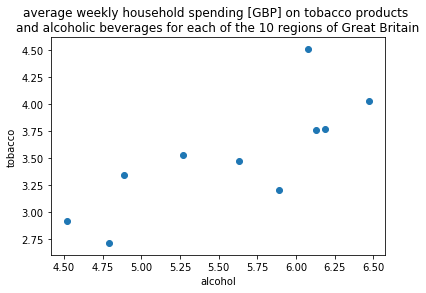

In [5]:
# filtering the data
altabac_filtered = altabac_data[altabac_data["Alcohol"] > 4.4]

# plot the data
plt.scatter(altabac_filtered["Alcohol"], altabac_filtered["Tobacco"])

plt.title("average weekly household spending [GBP] on tobacco products \
\nand alcoholic beverages for each of the 10 regions of Great Britain")

plt.xlabel("alcohol")
plt.ylabel("tobacco")
plt.show()

I will use two way of calculations: using **pandas** methods and **numpy** library calculations. For the last, to work with the data we need to transform it in numpy array that represents a matrix.

In [6]:
# cheking the type of each column separated we got an answer that itis <class 'pandas.core.series.Series'>
print(type(altabac_filtered["Alcohol"]))

# set the data for Alcohol as the first row. the Tobacco as the second row - each row represents one dimension
data = [altabac_filtered["Alcohol"], altabac_filtered["Tobacco"]] 
print(type(data)) # list

# the dimentions should be put as columns
data = np.array(data).T
print(type(data))
print("the shape of the smaple data =", data.shape)

<class 'pandas.core.series.Series'>
<class 'list'>
<class 'numpy.ndarray'>
the shape of the smaple data = (10, 2)



-- As PCA is linked with the covariances among which it chooses the dominant one, in order not to be misleaded by some dimension that is using a much lower dimensions and thus the numbers in this dimension would be significantly higher, there is a need to normalize each dimension to zero mean and scale it to the unit variance:
$$x^{\prime} = \frac{(x - \bar{x})}{\sigma}$$

for that equation we know it is defined as the Z-score.

In Python  we can use the function `StandardScaler` using `from sklearn.preprocessing import StandardScaler` (Source: YouTube https://www.youtube.com/watch?v=4KuF5HRAQn8&list=PLupD_xFct8mFgtBPBHAAmYbUgqDzzKOlP&index=9). We can also preprocess the data using the `normalize` function from the same library and we can use it to "column standardize" the matrix or set their values between $0$ and $1$ (Source: https://stackoverflow.com/questions/29661574/normalize-numpy-array-columns-in-python).

In [7]:
# # in our case it is not needed to standardize the data, because they ar both in GBP,
# # but it is generally strongly recommended to do so...
# # standardize the data using StandardScaler:
# from sklearn.preprocessing import StandardScaler 
# standardized_data = StandardScaler().fit_transform(data)
# # normalize the data using normalize
# from sklearn.preprocessing import normalize
# normalized_data = normalize(data, axis = 1)
# print(standardized_data.shape)
# print(normalized_data.shape)

-- we center the points in the mean to eliminate it and simplify our job.

In [8]:
# calculation of the mean and centering the data
mean_data = np.mean(data, axis = 0)
centered_data = data - mean_data

-- we compute the covariance matrix $\Sigma$.

In [9]:
# calculation of covariance matrix using numpy calculcation = X^T @ X / (n - 1)
# or using np.matmul(): covariance_martix = np.matmul((data - mean_data).T, data - mean_data)
covariance_matrix = centered_data.T @ (centered_data) / (centered_data.shape[0] - 1) 
print("covariance_matrix_numpy_calculated = \n", covariance_matrix)

#calculation using the calculation in numpy
cov_matrix = np.cov(centered_data, rowvar = False) 
# If rowvar is True (default), then each row represents a variable, with observations in the columns. 
# Otherwise, the relationship is transposed: each column represents a variable, while the rows contain observations.
print("cov_matrix_incorporated_in_numpy = \n", cov_matrix)

c_m = np.cov(centered_data.T)
print("c_m_incorporated_in_numpy_transposed = \n", c_m)

# we can do that straigth from pandas using pd.DataFrame.cov()
#df = pd.Dataframe(data = altabac_filtered["Alcohol"], altabac_filtered["Tobacco"])
#print(df)
covariance_matrix1 = altabac_filtered.cov()
print("covariance_matrix_calculated_via_pandas = \n", covariance_matrix1)

covariance_matrix_numpy_calculated = 
 [[0.45942667 0.28094   ]
 [0.28094    0.27929333]]
cov_matrix_incorporated_in_numpy = 
 [[0.45942667 0.28094   ]
 [0.28094    0.27929333]]
c_m_incorporated_in_numpy_transposed = 
 [[0.45942667 0.28094   ]
 [0.28094    0.27929333]]
covariance_matrix_calculated_via_pandas = 
           Alcohol   Tobacco
Alcohol  0.459427  0.280940
Tobacco  0.280940  0.279293


-- we find the $eigenvalues$ and the $eigenvectors$ of the covariance matrix $\Sigma$ (or correlation matrix, or perform Singular Value Decomposition). The $eigenvectors$ should be transformed to their respective unit vectors, meaning they have to be their unit length. An options is to use `np.linalg.eig()` from `numpy` library. The `numpy.linalg.eig` function returns a tuple consisting of a vector and an array. The eigenvalue 0 (from eigenvalues' vector) goes with the 0th column of eigenvectors' matrix.

There is another option from another library: `scipy.linalg.eigh()` from `scipy` library. When using the `eigh()` function we have to bear in mind that the values are sorted in ascending order, so we will need the last $k$-eigenvalues and eigenvectors. This can be extracted automatically using the `eigvals=()` parameter in the function. According to some sources (https://stackoverflow.com/questions/13224362/principal-component-analysis-pca-in-python) we'd better "use 'eigh' rather than 'eig' since R is symmetric, the performance gain is substantial".

In [10]:
eigvalues, eigvectors = np.linalg.eig(covariance_matrix)
print("eigvalues =", eigvalues)
print("eigvectors =\n", eigvectors)

# check if the np.linalg.eig() function is applicable on all different types of covariance matrix we calculated
print("="*25)
eigvl, eigvec= np.linalg.eig(covariance_matrix1)
print("eigvalues: ", eigvl == eigvalues)
print("eigvectors: \n", eigvec == eigvectors)


eigvalues = [0.66438422 0.07433578]
eigvectors =
 [[ 0.80786313 -0.58937014]
 [ 0.58937014  0.80786313]]
eigvalues:  [ True  True]
eigvectors: 
 [[ True  True]
 [ True  True]]


The typical goal of a PCA is to reduce the dimensionality of the original feature space by projecting it onto a smaller subspace, where the eigenvectors will form the axis. However, the eigenvectors only define the directions of the new axis, since they have all the same unit length 1, which can confirmed by the following two lines of code (the eigenvectors given by `np.linalg.eig()` are normalized so their Euclidean norms are 1):

In [11]:
for ev in eigvectors.T:
    np.testing.assert_equal(1.0, np.linalg.norm(ev))
print('Everything ok!')

Everything ok!


-- we end up with $d$ number of $eigenvalues$, but we do not want all of them. We pick $k$ biggest $eigenvalues$ where the % of explained variance correspond to the one we want to capture, and

Eigenvalues in descending order:
0.6643842160305566
0.07433578396944351


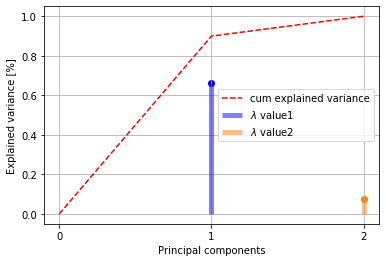


explained variance on eigenvalue_1 [%] = 89.94
eigenvector corresponding eigenvalue_1: [0.80786313 0.58937014]


In [12]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(eigvalues[i], eigvectors[:,i]) for i in range(len(eigvalues))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
print('Eigenvalues in descending order:')
for i in eig_pairs:
    print(i[0])

# plot the _explained variance_ and the different eigenvalues (principal components) in ascending order
expl_variance = [0]
lambda_count = [0]
sum_lambdas, count_lambda = 0, 0
for i, c in zip(eig_pairs, ['b', 'tab:orange']): #zip is needed due to colors
    sum_lambdas += i[0]
    count_lambda += 1
    # plot the scatter values of eigenvalues
    plt.scatter(count_lambda, i[0], c = c)
    # plot the vertical lines to the height of the eigenvalues in the same colors as the plotted scatter values
    plt.vlines(count_lambda, 0, i[0], color = c, linewidth = 5, label = f'$\lambda$ value{count_lambda}', alpha = 0.5)
    expl_variance.append(sum_lambdas /(eig_pairs[0][0] + eig_pairs[1][0]))
    lambda_count.append(count_lambda) # x-axis is the number of eigenvalues

plt.plot(lambda_count, expl_variance, ls='--', c = 'r', label = "cum explained variance")
plt.xticks(ticks = lambda_count)
plt.xlabel("Principal components")
plt.ylabel("Explained variance [%]")
plt.grid()
plt.legend()
plt.show()

# Visualize the values for lambda1
explained_value_lambda1 = 100 * eig_pairs[0][0]/sum_lambdas
print(f"\nexplained variance on eigenvalue_1 [%] = {explained_value_lambda1:.2f}")
PC1_vector = eigvectors[:,0]
PC2_vector = eigvectors[:,1]
print("eigenvector corresponding eigenvalue_1:", PC1_vector)

-- we project each feature to those $eigenvectors$ by using a dot product between the data instances and the eigenvector

(10, 3)
(10, 2)
(2,)
   1st principal component  2nd principal component
0                 1.012372                -0.112224
1                 0.578569                -0.129962
2                 0.632934                -0.157245
3                -0.670717                 0.261555
4                 0.003720                -0.069557
5                -1.217162                 0.140319
6                 0.054634                -0.440916
7                -1.122806                -0.188462
8                -0.251749                 0.191088
9                 0.980203                 0.505404


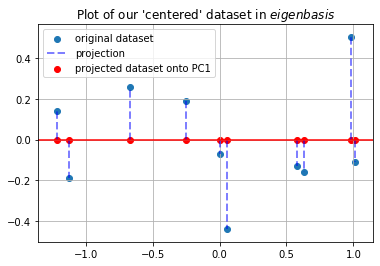

In [13]:
print(altabac_filtered.shape)
print(data.shape)
print(PC1_vector.shape)

new_coordinates1 = PC1_vector @ centered_data.T
new_coordinates2 = eigvectors[:,1] @ centered_data.T

dataframe = pd.DataFrame(data = new_coordinates1, columns = ["1st principal component"])
dataframe["2nd principal component"] = new_coordinates2
print(dataframe)

# 100% reversing the data using both components, but centered on the mean
plt.scatter(dataframe["1st principal component"], dataframe["2nd principal component"], label = "original dataset")
plt.vlines(dataframe["1st principal component"], 0, dataframe["2nd principal component"], color = 'b', linestyle = '--', label = "projection", linewidth = 2, alpha = 0.5)

# new projected values of our data set (only based on teh 1st component)
plt.scatter(dataframe["1st principal component"], np.zeros(10, ), c = 'r', label = "projected dataset onto PC1")

# color in red the first component
plt.axhline(0, 0, c = 'r')

plt.title("Plot of our 'centered' dataset in $eigenbasis$ ")
plt.legend()
plt.grid()
plt.show()

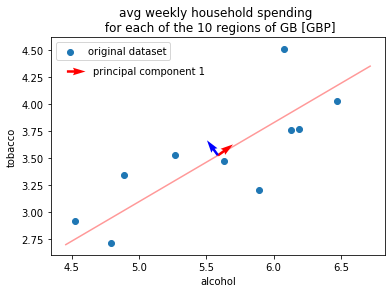

In [14]:
# filtering the data
altabac_filtered = altabac_data[altabac_data["Alcohol"] > 4.4]

# plot the data
plt.scatter(altabac_filtered["Alcohol"], altabac_filtered["Tobacco"], label = "original dataset")
Q = plt.quiver([mean_data[0], mean_data[0]], [mean_data[1], mean_data[1]], [PC1_vector[0], PC2_vector[0]], [PC1_vector[1],  PC2_vector[1]], color = ["red", "blue"], alpha = 1)
plt.quiverkey(Q, 4.6, 4.3, 1, coordinates = 'data', label = "principal component 1", color = "red", labelpos = 'E')

# Add first component axis line
#axes = plt.gca()
X_plot = np.linspace(-1.4 , 1.4, 2)
plt.plot(mean_data[0] + X_plot * PC1_vector[0], mean_data[1] + X_plot * PC1_vector[1],  color = "red", alpha = 0.4)

plt.title("avg weekly household spending \
\n for each of the 10 regions of GB [GBP]")

plt.xlabel("alcohol")
plt.ylabel("tobacco")
plt.legend()
plt.show()

### PCA using scikit-learn

All that can be done using the `scikit-learn` library. Beforehand we need to import `from sklearn.decomposition import PCA`.

In [15]:
#initializing the pca
pca = PCA()

#configuring the parameters
pca.n_components = 1
pca_data = pca.fit_transform(data)

#pca reduced will contain the 1-d project of data
print("shape of pca reduced = ", pca_data.shape)

shape of pca reduced =  (10, 1)


In [16]:
# checking whether the biggest eigenvalues and calculated explained variance correspond to the previous method of calculation
print([explained_value_lambda1 / 100] == pca.explained_variance_ratio_)

dataframe = pd.DataFrame(data = pca_data, columns = ["1st principal component"])
dataframe

[ True]


,1st principal component
0,-1.012372
1,-0.578569
2,-0.632934
3,0.670717
4,-0.003720
5,1.217162
6,-0.054634
7,1.122806
8,0.251749
9,-0.980203


### PCA using openCV

Of course, there are other libraries that have PCA as a finction. As for example `openCV` uses the class PCA applying the following code: `mean, eigenvectors = cv2.PCACompute ( data, mean=mean, maxComponents=maxComponents )`.

#### Eigenfaces algorithm

To show another great use of **PCA** along with $eigenvalues$ and $eigenvectors$ I will implement the first steps of **feature detection**. In one algorithm, called **eigenfaces**, if you receive many images of faces, you can see "what makes a face". The principal characteristics of a face can be extracted using the **PCA** algorithms.


* How are images represented?

Just as an example: A 100 x 100 color image is nothing but an array of 100 x 100 x 3 ( one for each R, G, B color channel ) numbers. Usually, we like to think of 100 x 100 x 3 array as a 3D array, but you can think of it as a long 1D array consisting of 30,000 elements. You can think of this array of 30k elements as a point in a 30k-dimensional space just as you can imagine an array of 3 numbers (x, y, z) as a point in a 3D space! How do you visualize a 30k dimensional space? You can’t. Most of the time you can build your argument as if there were only three dimensions, and usually ( but not always ), they hold true for higher dimensional spaces as well. (Source: Eigenface using OpenCV (C++/Python) - Satya Mallick - JANUARY 18, 2018  https://www.learnopencv.com/eigenface-using-opencv-c-python/)

So, the thing we need to do first is to pre-process the dataset (allign and resize the set of images, all of them representing faces, and all of them with correct face allignment - this would be extremely important if we use face recognition from real-time videao stream):


1. we input a dataset of N face images, all of the images in the same $k$-dimension.
(In the case below I used images from this source: http://vis-www.cs.umass.edu/lfw/#download, as they were already labeled. The idea came from this blog: https://blog.cambridgespark.com/50-free-machine-learning-datasets-image-datasets-241852b03b49).

The function created for this purpose is called `read_images`. As argument it takes the folder path. As we use openCV< I use the `imread()` function from this library.

In [17]:
def read_images(dir_name):
    
    files = [f for f in listdir(dir_name) if isfile(join(dir_name, f)) ]
    images = np.empty(len(files), dtype=object)
    for n in range(len(files)):
        images[n] = cv2.imread(join(dir_name, files[n]))
    
    return(images)

* How are the images transformed?


2. we have to form a sigle vector by unfolding the picture in 1 big vector -> first row becomes the 1st $k$ attributes of our vector, ... last row the last $k$, so the total lenght of this vector becomes $k^2$. This should be further multiplied by the number of channels. In case of RGB picture we should muliply it by 3.

3. we end up with a matrix of $k^2 * 3$ rows and N columns (for each face).

I called the function `create_data_matrix` and it takes as arguments the dataset and the shape of the images.

In [18]:
def create_data_matrix(images, sz):
    print("Creating data matrix", end=" ... ")
    ''' 
    Allocate space for all images in one data matrix. 
        The size of the data matrix is
        ( k (image width)  * k (image height) * 3, number of images in dataset N)    
        '''
    num_images = len(images) # this is the sample size (number of images)
    # creating empty matrix with N (nimber of images) rows and (k x k x 3 (for R, G, B)) columns
    data = np.zeros((num_images, sz[0] * sz[1] * sz[2]), dtype=np.float32) 
    for i in range(num_images):
        # filling each row of "data" matrix with flatten images in row-major (C-style) order - 1st row1, than row 2, ... etc.
        data[i,:] = images[i].flatten()

    print("DONE")
    return(data)

* What is an eigenface?


4. we do **PCA** - 
 - take the data matrix and substract the mean of all pictures (all the common features that creates the average *face* vector $\vec{M}$), so that we remain with the **Normalized "face" vectors / matrix** $\Phi_i$
 - Generally using stadard PCA we will have to compute the cov matrix $\Sigma = \Phi \Phi^T$ of the remaining *normalized "face" vectors matrix* that will have the size of $k^2 (\times 3) \times N$ so $\Sigma$ will be of $k^2 \times k^2 (\times 9)$ size. The calculated $eigenvalues$ and $eigenvectors$ $\vec{v}$ numbers will be also $k^2 (\times 3)$. $(\times 3)$ and $(\times 9)$ are added in case of dataset of 3 channel.
 - In some cases it is too hard to compute this as the $k^2$ can be too large ($(\times 3)$ even larger). For such cases, in 1991 M. Turk and A. Pentland showed a way of calculating the eigenvectors of a covariance matrix such that computers can perform eigen-decomposition on a large number of face images(Source: [Wikipedia](https://en.wikipedia.org/wiki/Eigenface) M. Kirby; L. Sirovich (1990). "Application of the Karhunen-Loeve procedure for the characterization of human faces". IEEE Transactions on Pattern Analysis and Machine Intelligence. 12 (1): 103–108. doi:10.1109/34.41390): in order to decrease the computational ressources needed we can use a calculation based on covariance matrix of reduced dimentionality, where $\Sigma = \Phi^{T} \Phi$, thus the size of $\Sigma$ will be $N \times N$ and we will get to $N$ number of $eigenvalues$ and $eigenvectors$ $\vec{u}$. Thanks to Linear Algebra we know that the $\vec{v} = \Phi \vec{u}$. That is the way to map back to the original array of $eigenvectors$ $\vec{v}$. An additional advantage of this method is that we avoid and reduce the evential noise in the pictures that can be taken incorrectly as some important $eigenface$.
5. at the end of **PCA** we pick the certain number of "$m$", such that it contains the vectors with the highest values. The new "*reconstructed*" matrix is now $k^2 (\times 3)$ rows and $m$ - columns. We say that that way we generate a set of $m$ $eigenfaces$.

6. if we take one and folding pack to picture $k \times k (\times 3)$. It doesn't look to a face, but we can see where are the most variations.

In [62]:
def plot_1image(face, sz):
    # show the picture
    plt.figure(figsize = (6, 6))

    # due to the way cv2 read images in the range from 0 to 255
    # https://stackoverflow.com/questions/49643907/clipping-input-data-to-the-valid-range-for-imshow-with-rgb-data-0-1-for-floa
    plt.imshow(face.reshape(sz) / 255) 
    
    plt.show()

def show_images(eigenfaces, sz):
    rows = 4
    if len(eigenfaces) % rows == 0:
        n = len(eigenfaces)
    else:
        n = len(eigenfaces) - len(eigenfaces) % rows
    
    f = plt.figure(figsize=(15, 6))
    for i in range(n):      
        # Debug, plot figure
        f.add_subplot(rows, n / rows, i + 1)
        plt.imshow((eigenfaces[i] * 255).astype(np.uint8))
        plt.axis("off")

    plt.show(block=True)

size of an image =  (250, 250, 3)
Creating data matrix ... DONE
Calculating PCA ...DONE

Plotting the mean (average face)...


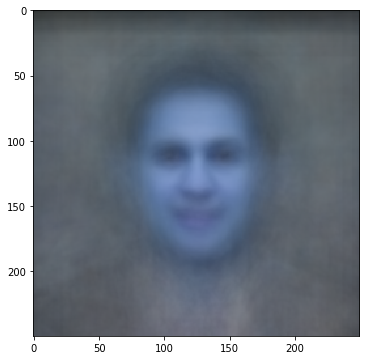


Plotting the top Eigenfaces...(out of 38 eigenvectors generated for the desired 80.0% explained variance)


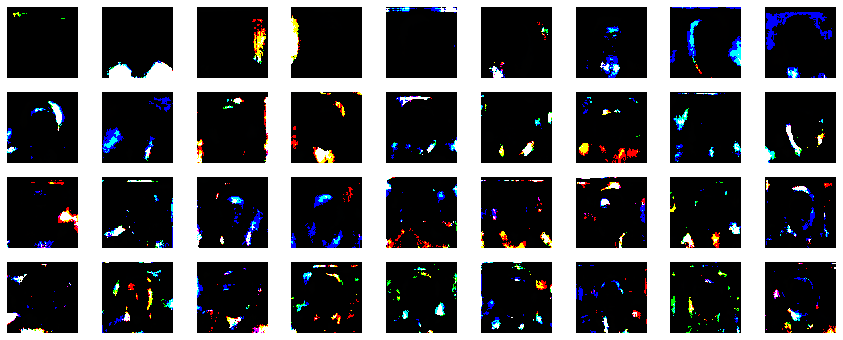

In [63]:
# Number of EigenFaces
# # optional
# NUM_EIGEN_FACES = 9

# Directory containing images
dir_name = "data\\training"

# Read images
images = read_images(dir_name)
#print(images)

# Size of images
sz = images[0].shape
print("size of an image = ", sz)

# Create data matrix for PCA.
data = create_data_matrix(images, sz)

# Compute the eigenvectors from the stack of images created for the retainedVariance "expl_var" we desire
expl_var = 0.8
print("Calculating PCA ", end="...")
mean, eigenVectors = cv2.PCACompute(data, retainedVariance = expl_var, mean= None)
# mean, eigenVectors = cv2.PCACompute(data, mean= None, CV_PCA_DATA_AS_ROW= True, maxComponents = NUM_EIGEN_FACES)
print ("DONE")

print("\nPlotting the mean (average face)...")
plot_1image(mean, sz)

eigenFaces = []
for eigenVector in eigenVectors:
    eigenFace = eigenVector.reshape(sz)
    eigenFaces.append(eigenFace)

print(f"\nPlotting the top Eigenfaces...(out of {len(eigenVectors)} eigenvectors generated for the desired {expl_var*100}% explained variance)")
show_images(eigenFaces, sz)

# in case we used cv2.imshow() we should have used:
# Hit ESC to terminate program
# cv2.waitKey(0)
# cv2.destroyAllWindows()

Unfortunately, the `PCACompute` function of `OpenCV` do not show the $eigenvalues$. Luckily, we can pass the desired explained variance as argument to the function (called "retainedVariance") or use the option to show a concrete number of $eigenfaces$ using another argument "maxComponents".


For the purpose of showing the PCA analysis I will stop the implementation at this point.


The process of reconstructing or detecting a face should continue by precessing further the procedure:

7. To go back and reconstruct a face we need to take these $m$ $eigenfaces$ each with its proportional *weigth* $w$ (thus creating the *weight vector* $\vec{w}$) and add to them the "*average* face *vector* $M$".
$$face_i = \sum_{m} w_{im} eigenface_i + M$$


As a downside, we can say that whatever you try to reconstruct via Eigenface, PCA will represent it in a way it is a face - this is the only thing it can represent. There are also ways to overcome this problem.

* Use the algorithm for face detection **in an unknown image**

As said above Eigenfaces can be used for Face Recognition.
How can it happen. If we input an "unknown" image we need to:
- convert it again to a face vector $\vec{U}$
- we need to "normalize" this face vector (subtracting the "trained" mean that we called above the "average *face* vector $M$")
- project this "normalized" face vector onto the $eigenspace$, meaning to represent this face as a combination of $m$ eigenfaces as we have done in training the recongnizer. $w_m = \Phi_m ^T (U - M)$
- this will result the *weight vector* $\vec{W}$ for the unknown input face.
- now we need to calculate the "distance" between input *weight vector* and all the *weight vectors* of the training set. $$d = \|{W - W_m}\|^2$$
- this "distance" should be compared with initially choosen during the training "threshold" and if the "distance" is above, the face will be recognized and might give back the label, if not, it will remain unknown.
(Source: Getting Started with Face Recognition - Mahvish Nasir - http://fewtutorials.bravesites.com/)

One of the main reasons we use PCA is for transforming a X-dimensional space to 3, 2 or 1-dimension is that we are able to plot, or to 'visualize'.

***IV.*** **Conclusion**. In practice:

In Machine Learning we use statistics as a base. But when there are too many dimentions, the observervations per region (per dimension) decreases. So it is less and less redundancy for the learning algorithm. As statistics needs repetition we have to reduce the dimension by increasing in same time the observations in the dimensions. When you do not have specific "domain knowledge" (specific software, format etc. depending on the domain) it is often convenient to use PCA, because it is preserving as much of the desired structure (shape, variance, specific feature/attribute) as possible.

PCA has been called, ’one of the most important results from
applied linear algebra’[Source:  Jonathon Shlens, A Tutorial on Principal Component Analysis, http://www.brainmapping.org/NITP/PNA/Readings/pca.pdf] and perhaps its most common use is as the first step in trying to analyse large data sets. Some of the other common applications include; de-noising signals, blind source separation, face recognition (Eigenfaces) and data compression.

*Misuses and alternatives:*

- One misuse of PCA may be linked with the fact that PCA assumes that the subspace is linear. In case it is not, it will be transformed in a linear space which will result in lots of errors and distortions. A way to go arround in such cases is to split the non-linear space (datasets) to subsets that are close to linear sets (spaces).

- Once you have done the projection, every point is represented as a number, a **scalar** that scale the eigenvector, which in some cases (for instance concerning classifications) could erase am important setting and there is no way to separate them again based on this attribute (dimension). In such case you would better use a discriminative approach and look for a dimension that makes it easy to separate classes. So, the solution would be the $eigenvectors$ based on between-class and within-class covariance matrices.

There is a technic that is similar to PCA, called LDA (Linear Discriminant Analysis). It looks at the $$max \frac{(\bar{x}_1 - \bar{x}_2)^2}{\sigma_1^2 + \sigma_2^2}$$
and it maximazes the differences between the means of the classes normalized by their variances. It does that under several assumptions - that the data is Gaussian and there are some boundries between the datapoints ao ti fails when discriminatory information is not in the mean, but in the variance of data.

In other words, PCA projects the entire dataset onto a different feature (sub)space, and LDA tries to determine a suitable feature (sub)space in order to distinguish between patterns that belong to different classes.

- When covariance matrix is of too big size (that happend when the dimensions are too many) we can use the **SVD** technic - singular value decomposition, where the dataset represented with the matrix M will be: $$M = U \Sigma V^T$$  with $U$ $\Sigma$ and $V^T$ computed from the Correlation matrix.(Source: Steve Brunton "Singular Value Decomposition (SVD): Dominant Correlations" https://www.youtube.com/watch?v=WmDnaoY2Ivs&list=PLMrJAkhIeNNSVjnsviglFoY2nXildDCcv&index=4)


- There is also **ICA** (independent component analysis) that seeks for directions that are statistically independent, often measured using information theory. Usually **ICA** is used to find edges or components of the dataset.

- Another analysis is Kernel PCA that transforms input data to other spaces - when we cannot assume that points are multivariate Gaussian.